In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)

%matplotlib inline

问题

假设有两家电商A和B来找你投资,他们的情况分别如下:

A过去前面3个月发展了10000用户, B发展了20000用户，你投谁?
A的用户里面有6000人下单，B的用户有4000人下单，你投谁？
A的前3个月下过单的用户在第4个月只有1000继续下单，B的则还有3000？投谁？


考察数据需要多个纬度，新增用户，转化，留存...。对数据分析而言我们需要把数据分组进行分析，这里就需要用到Cohort Analysis（分组分析/同期群分析）。

Cohort其实是一个组群的意思，所以Cohort Analysis就是分组分析。而在实际分析里，最常用到的一种Cohort Analysis就是按照不同时期进入的用户，分别考察其后续的行为情况（比如分别统计第一个月、第二个月、第三个月……获取的新客户在后续几个月的下单情况），所以又可以叫做同期群分析。


1）横向比较，可以看出每月新增用户在后续各月的留存率情况。

2）纵向比较，可以看出不同月份新增用户，分别在当月、下个月、下下个月等的留存表现如何。

对应这两点一家好的公司应该看到的趋势是：

1）横向的留存数据最终会在某个月份之后停留在一个固定的留存率上，比如某个月获取的100个用户，在半年后每个月的留存率都稳定在60%，这就说明这批用户是稳定留存下来的，不然如果留存率是一直下降的（哪怕下降的速度很慢），也会在之后的某个月份归零，也就是说不管新增多少用户，最终都一个都剩不下。

2）纵向的留存数据应该是越来越好的。因为公司和创始团队应该不断的根据历史情况改进产品和体验等，所以越后加入的用户，应该能享受到越好的产品和服务，后续几个月的留存率就应该更高。

对app或者网站而言不仅是要人下载，使用你的程序，同时还需要让他们重复使用。因此下载率，日活/月活只是度量的一方面，我们还需要更进一步进行群组分析（Cohort analysis）

Cohort是行为分析的一种，它将用户分成相关的组后再进一步分析。而相关组通常具有相同特征，比如注册日期，首次购买月，获取渠道等等。通常的Cohort analysis分为：

+ Acquisition Cohorts: divide users by when they signed up first for your product. For your app users, you might break down your cohorts by the day, the week or the month they launched an app, and thereby track daily, weekly or monthly cohorts.
In this case, by measuring the retention of these cohorts, you can determine how long people continue to use your app from their start point.

+ Behavioral Cohorts: divide users by the behaviors they have (or haven’t) taken in your app within a given time period. These could be any number of discrete actions that a user can perform – App Install, App Launch, App Uninstall, Transaction or Charged, or any combination of these actions / events.

Cohort Analysis可以理解你的业务是否健康-客户是否具有粘性，我们可以利用它来对客户留存以及流失进行可视化分析，从何帮助我们了解客户的生命周期价值。

http://www.kdnuggets.com/2016/05/clevertap-use-cohort-analysis-improve-customer-retention.html

In [2]:
df = pd.read_excel('../data/relay-foods.xlsx',sheetname='Purchase Data - Full Study')
df.head(5)

,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20
2,294,2009-02-03,47,38.71,3TRDC,2,2009-02-04
3,301,2009-02-06,47,53.38,NGAZJ,2,2009-02-09
4,302,2009-02-06,47,14.28,FFYHD,2,2009-02-09


### 基于OrderDate来对订单按月分类

我们这里进行的是按月进行群组分析

In [3]:
df['OrderPeriod'] = df.OrderDate.apply(lambda x: x.strftime('%Y-%m'))
df.head()

,OrderId,OrderDate,UserId,TotalCharges,CommonId,PupId,PickupDate,OrderPeriod
0,262,2009-01-11,47,50.67,TRQKD,2,2009-01-12,2009-01
1,278,2009-01-20,47,26.60,4HH2S,3,2009-01-20,2009-01
2,294,2009-02-03,47,38.71,3TRDC,2,2009-02-04,2009-02
3,301,2009-02-06,47,53.38,NGAZJ,2,2009-02-09,2009-02
4,302,2009-02-06,47,14.28,FFYHD,2,2009-02-09,2009-02


### 根据首次购买日期决定用户的群组

用新的列CohortGroup来代表群组（首次购买的年月）

In [4]:
df.set_index('UserId', inplace=True)
df.head()

,OrderId,OrderDate,TotalCharges,CommonId,PupId,PickupDate,OrderPeriod
UserId,,,,,,,
47,262,2009-01-11,50.67,TRQKD,2,2009-01-12,2009-01
47,278,2009-01-20,26.60,4HH2S,3,2009-01-20,2009-01
47,294,2009-02-03,38.71,3TRDC,2,2009-02-04,2009-02
47,301,2009-02-06,53.38,NGAZJ,2,2009-02-09,2009-02
47,302,2009-02-06,14.28,FFYHD,2,2009-02-09,2009-02


In [5]:
df['CohortGroup'] = df.groupby(level=0)['OrderDate'].min().apply(lambda x: x.strftime('%Y-%m'))
df.reset_index(inplace=True)

In [14]:
df.head()

,UserId,OrderId,OrderDate,TotalCharges,CommonId,PupId,PickupDate,OrderPeriod,CohortGroup
0,47,262,2009-01-11,50.67,TRQKD,2,2009-01-12,2009-01,2009-01
1,47,278,2009-01-20,26.60,4HH2S,3,2009-01-20,2009-01,2009-01
2,47,294,2009-02-03,38.71,3TRDC,2,2009-02-04,2009-02,2009-01
3,47,301,2009-02-06,53.38,NGAZJ,2,2009-02-09,2009-02,2009-01
4,47,302,2009-02-06,14.28,FFYHD,2,2009-02-09,2009-02,2009-01


###  根据CohortGroup 以及 OrderPeriod进行数据汇总

根据CohortGroupSince对各OrderPeriod进行汇总

In [7]:
grouped = df.groupby(['CohortGroup', 'OrderPeriod'])

# 不同用户数，订单数以及总的收入
cohorts = grouped.agg({'UserId': pd.Series.nunique,
                       'OrderId': pd.Series.nunique,
                       'TotalCharges': np.sum})

cohorts.rename(columns={'UserId': 'TotalUsers',
                        'OrderId': 'TotalOrders'}, inplace=True)
cohorts.head()

TotalCharges  TotalOrders  TotalUsers
CohortGroup OrderPeriod                                       
2009-01     2009-01          1850.255           30          22
            2009-02          1351.065           25           8
            2009-03          1357.360           26          10
            2009-04          1604.500           28           9
            2009-05          1575.625           26          10

### 每个CohortGroup在每个CohortPeriod的购买行为

要研究每个CohortGroup在首次购买后的每个CohortPeriod的购买行为，那么我们CohortPeriod = 1 代表第一个月，CohortPeriod = 2代表第二个月

In [10]:
def cohort_period(df):
  
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

TotalCharges  TotalOrders  TotalUsers  CohortPeriod
CohortGroup OrderPeriod                                                     
2009-01     2009-01          1850.255           30          22             1
            2009-02          1351.065           25           8             2
            2009-03          1357.360           26          10             3
            2009-04          1604.500           28           9             4
            2009-05          1575.625           26          10             5

### 按照CohortGroup计算留存留存

那么我们需要计算每个CohortGroup的开始的大小

In [11]:
# reindex 
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()
cohort_group_size.head()

CohortGroup
2009-01    22
2009-02    15
2009-03    13
2009-04    39
2009-05    50
Name: TotalUsers, dtype: int64

留存需要用当前总用户数除以开始的总用户数目。这里我们需要使用到unstack

In [14]:
cohorts['TotalUsers'].head(10)

CohortGroup  CohortPeriod
2009-01      1               22
             2                8
             3               10
             4                9
             5               10
             6                8
             7                8
             8                7
             9                7
             10               7
Name: TotalUsers, dtype: int64

In [35]:
cohorts['TotalUsers'].unstack(0).head()

CohortGroup,2009-01,2009-02,2009-03,2009-04,2009-05,...,2009-11,2009-12,2010-01,2010-02,2010-03
CohortPeriod,,,,,,,,,,,
1,22.0,15.0,13.0,39.0,50.0,...,130.0,65.0,95.0,100.0,24.0
2,8.0,3.0,4.0,13.0,13.0,...,32.0,17.0,50.0,19.0,NaN
3,10.0,5.0,5.0,10.0,12.0,...,26.0,18.0,26.0,NaN,NaN
4,9.0,1.0,4.0,13.0,5.0,...,29.0,7.0,NaN,NaN,NaN
5,10.0,4.0,1.0,6.0,4.0,...,13.0,NaN,NaN,NaN,NaN


In [15]:
user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head(10)

CohortGroup,2009-01,2009-02,2009-03,2009-04,2009-05,...,2009-11,2009-12,2010-01,2010-02,2010-03
CohortPeriod,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.00,...,1.000000,1.000000,1.000000,1.00,1.0
2,0.363636,0.200000,0.307692,0.333333,0.26,...,0.246154,0.261538,0.526316,0.19,NaN
3,0.454545,0.333333,0.384615,0.256410,0.24,...,0.200000,0.276923,0.273684,NaN,NaN
4,0.409091,0.066667,0.307692,0.333333,0.10,...,0.223077,0.107692,NaN,NaN,NaN
5,0.454545,0.266667,0.076923,0.153846,0.08,...,0.100000,NaN,NaN,NaN,NaN
6,0.363636,0.266667,0.153846,0.179487,0.12,...,NaN,NaN,NaN,NaN,NaN
7,0.363636,0.266667,0.153846,0.102564,0.06,...,NaN,NaN,NaN,NaN,NaN
8,0.318182,0.333333,0.230769,0.153846,0.10,...,NaN,NaN,NaN,NaN,NaN
9,0.318182,0.333333,0.153846,0.051282,0.10,...,NaN,NaN,NaN,NaN,NaN


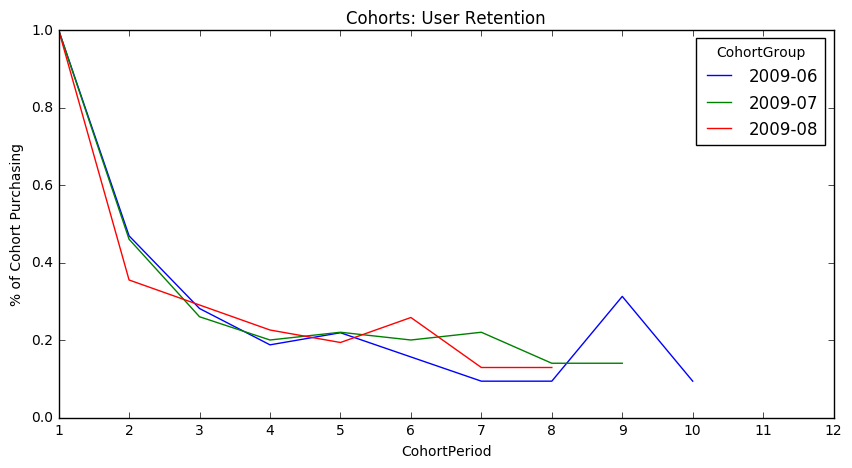

In [37]:
user_retention[['2009-06', '2009-07', '2009-08']].plot(figsize=(10,5))
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 12)
plt.ylabel('% of Cohort Purchasing');

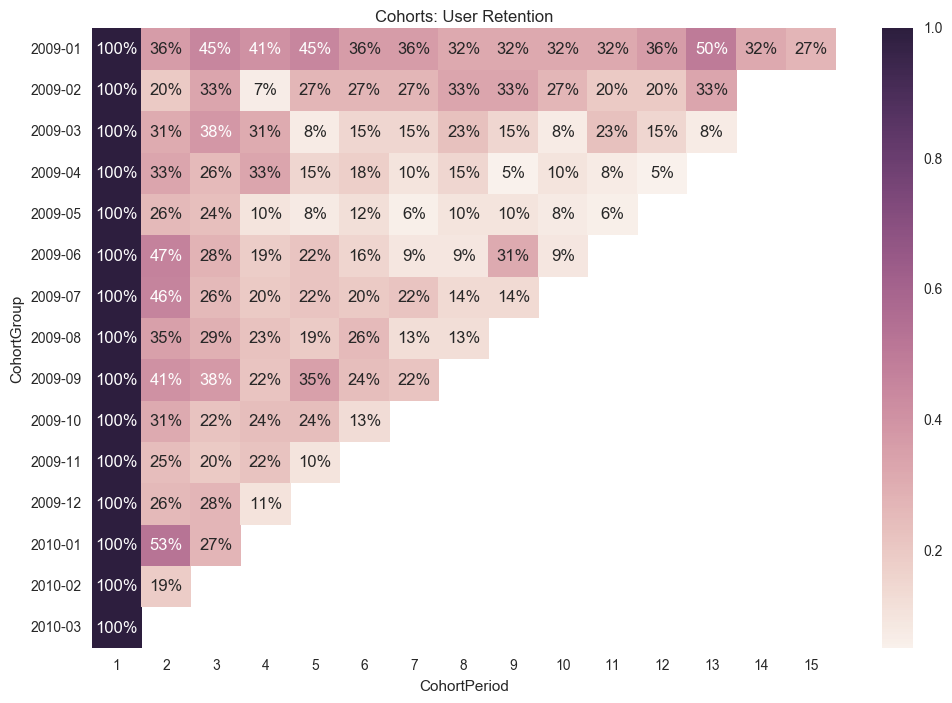

In [19]:
import seaborn as sns
sns.set(style='white')

plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T,  mask=user_retention.T.isnull(),annot=True, fmt='.0%');

In [18]:
sns.heatmap?